# Linear regression

In regression, we aim to find a function $f$ that maps inputs $x ∈ R^D$ to corresponding function values $f (x) ∈ R$. We assume we are given a set of training inputs xn and corresponding noisy observations $y_n = f (x_n )+ϵ$, where ϵ is an i.i.d. random variable that describes measurement/observation noise and potentially unmodeled processes.

In this tutorial we will go through the basics of linear regression and how we can calculate the weights of a function to fit the given dataset first using a **closed form solution** and then using **gradient descent**. We will also try to understand the **effect regularization**. We will only be using the numpy module, meaning we will not be using any prebuilt libraries for machine learning, but write our own functions to perform the linear regression.

In [62]:
import numpy as np
import pandas as pd

import matplotlib.animation
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

from time import time
import tqdm

#from IPython.display import display, clear_output

#%matplotlib notebook

## Fitting a polynomial curve to given data

We have as a given a small dataset which consists of $x$ and $y=f(x)$ data points. This data can be assumed to be representative of an arbitrary process which has essentially one independent variable $x$ and one output value $y$ which is a function of $x$.

We now want to obtain a description for $f(x)$ such that:

1. It describes the given data accurately
2. It is able to generalise to any $x$ values in the future.

Before doing anything let us look at the available data.

### Given dataset

We have 2 files in the folder. It is imperative that we **do not look at any of the test data** before creating the model. Looking at test data prior would be cheating.

Let us look at the train data, first in tabular format and then as a plot.

In [101]:
df = pd.read_csv("Linear_regression_train_data.csv")
df

x_train   y_train
0   0.879310 -1.023810
1   1.500000 -0.872766
2  -0.155172 -0.122405
3  -0.982759  0.712731
4   0.672414 -2.669142
5   0.258621 -0.134131
6   1.086207  0.934010
7  -0.465517 -2.264064
8  -0.672414 -3.000000
9  -1.500000 -2.041701
10  0.775862  0.048655
11 -0.568966 -0.735432
12  1.293103  0.747855
13 -0.258621 -0.967015
14 -0.051724 -1.106022
15 -0.362069 -0.948578
16  0.362069  0.117369
17  0.155172 -1.912120
18 -1.293103  2.490753
19  0.982759 -1.550368
20  0.568966 -1.376461
21  0.051724 -1.512949
22  1.396552  0.747985
23  0.465517 -2.750810

In [102]:
df.sort_values(by="x_train", inplace=True)
x_train = df["x_train"]
y_train = df["y_train"]

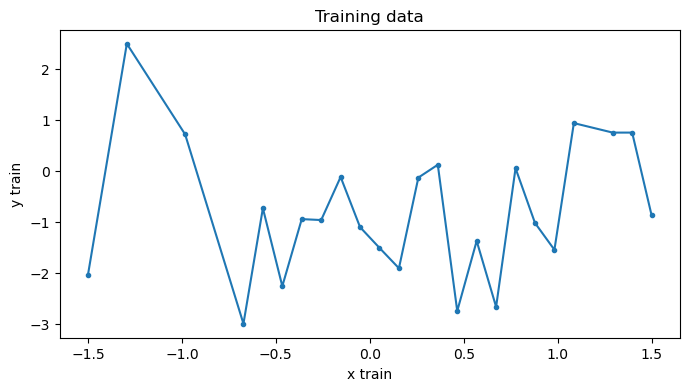

In [104]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(df["x_train"], df["y_train"], ".-")
ax.set_xlabel("x train")
ax.set_ylabel("y train")
ax.set_title("Training data")
plt.show()

## Developing a cost function

Before starting to develop a model, we need to develop a measure of how good or bad our model is. Essentially we need a measure to compare the predicted and actual values for $y$ 

For this reason we will use the Mean squared error. Which is defined as:

$MSE$ = $\frac{1}{2m} \Sigma_{i=0}^{m} (y_{predicted} - y_{actual})^2$

Here $m$ refers to the number of samples, which in our case is 160.

**Explaination of the formala**: for each of the $x$ values in $x_{train}$, we compute the difference between the predicted and the actual value, then square the difference. Now that we have a list of squared differences we simply calculate their arithemetic mean.

Let us see how that looks as a python function. The MSE is also referred to as the loss.

In [66]:
def get_loss(predictions, actuals):
    squared_differences = []
    for pred, act in zip(predictions, actuals):
        squared_differences.append((pred-act)*(pred-act))
    MSE = np.mean(squared_differences)
    
    return MSE

def get_loss_vectorised(prediction, actual):
    difference_vector = prediction - actual
    return np.matmul(difference_vector.T, difference_vector)/len(difference_vector)

### Let us test the small function which we have written with some fictional values

If both the predictions and actuals are the same we should get 0 as error/loss

In [105]:
get_loss([1,2,3], [1,2,3])

0.0

For predictions and actuals which each differ by just 2, the mean squared error should be 4

In [106]:
get_loss([1,2,3], [3,4,5])

4.0

## Vectorizing our function

Although the function above works well, we will run into issues when we are dealing with larger datasets.

***Loops in python are slower than vectorized implementations.***

This is mainly due to the optimizations which numpy carries out in its backend. For this reason we will rewrite the function above without using loops. All our subsequent functions will also be vectorized.

In [107]:
def get_loss_vectorised(prediction, actual):
    difference_vector = prediction - actual
    return np.matmul(difference_vector.T, difference_vector)/len(difference_vector)

In [108]:
get_loss_vectorised(np.array([1,2,3]), np.array([1,2,3]))

0.0

In [109]:
get_loss_vectorised(np.array([1,2,3]), np.array([5,6,7]))

16.0

## Choosing an appropriate model

The first step is to choose a model which could describe the data. With just the given data and no other information we could choose any mathematical function and try to calculate its coefficients, so in this case we will use a general polynomial of the form

$ f(x) = a_n x^n + a_{n-1} x^{n-1} + a_{n-2} x^{n-2} + \ {...} \ + a_{2} x^{2} + a_{1} x + a_0 $

The value of $n$ could be anything. For now let try with a polynomial with $(n=18)$, later on we will try with different order polynomials as well. So our model actually looks as follows:

$ f(x) = a_{18} x^{18} + a_{17} x^{17} + \ ... \ +a_{2} x^{2} + a_{1} x + a_0 $

Where we need to calculate the values of the feature vector **a**

Given are:
1. Values for $x$ as seen in $x_{train}$ above
2. Values for $f(x)$ or $y$ as seen in $y_{train}$ above
    

This example represents a typical case where we have multiple features influencing the output of a model but we do not know how to quantify their influence. 

We know the output and we know the input, but we do not know the exact relationship between these two. 

If we are able to calculate the coefficients sufficiently correctly, we can predict $f(x)$ for $x$ values which greater than 99 or less than 0 as well. In real world examples, it means we will be able to predict outputs for input data not yet seen by out model.

Let us now try to solve this problem and try to compute the correct values of $a$ and $b$ for the given values of $x$ and $f(x)$

## Closed form solution

Let's assume we have a dataset with `n` observations and `m` features. The features are represented by the vector `θ`.

The cost function for linear regression without regularization is given by:

$$J(θ) = \frac{1}{2n} \sum_{i=1}^{n} (h_θ(x^{(i)}) - y^{(i)})^2$$

where `h_θ(x)` is the hypothesis function given by:

$$h_θ(x) = θ^Tx$$

To find the closed form solution, we need to find the value of `θ` that minimizes the cost function `J(θ)`.

Taking the partial derivative of `J(θ)` with respect to `θ_j`, we get:

$$\frac{∂J(θ)}{∂θ_j} = \frac{1}{n} \sum_{i=1}^{n} (h_θ(x^{(i)}) - y^{(i)})x_j^{(i)}$$

Setting this derivative to 0 and solving for `θ`, we get:

$$\theta = (X^TX)^{-1}X^Ty$$

where `X` is the design matrix of shape `(n, m)` and `y` is the vector of target values of shape `(n,)`.

Let's derive this solution step by step.

First, let's expand the cost function:

$$J(θ) = \frac{1}{2n} \sum_{i=1}^{n} (h_θ(x^{(i)}) - y^{(i)})^2$$
$$= \frac{1}{2n} \sum_{i=1}^{n} (θ^Tx^{(i)} - y^{(i)})^2$$
$$= \frac{1}{2n} (Xθ - y)^T(Xθ - y)$$

where `X` is the design matrix of shape `(n, m)` and `y` is the vector of target values of shape `(n,)`.

Taking the derivative with respect to `θ`, we get:

$$\frac{∂J(θ)}{∂θ} = \frac{1}{n}(X^TX)θ - X^Ty$$

Setting this derivative to 0 and solving for `θ`, we get:

$$(X^TX)θ = X^Ty$$
$$(X^TX)^{-1}(X^TX)θ = (X^TX)^{-1}X^Ty$$
$$\theta = (X^TX)^{-1}X^Ty$$

In [114]:
def linear_regression_closed_form(x_train, y_train):
    a = np.linalg.inv(x_train.T @ x_train) @ x_train.T @ y_train
    return a

order_of_polynomial = 18
X_train_matrix = np.array([np.power(x_train, ix) for ix in range(order_of_polynomial)]).T

a = linear_regression_closed_form(X_train_matrix, y_train)

predictions = np.dot(X_train_matrix, a)

In [115]:
X_train_matrix.shape

(24, 18)

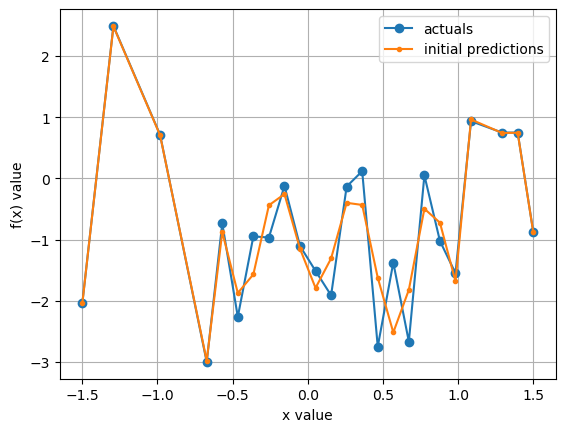

In [116]:
fig, ax = plt.subplots()
p1 = ax.plot(x_train, y_train, "-o", label="actuals")
p2 = ax.plot(x_train, predictions, ".-", label="initial predictions")
ax.legend()
ax.set_xlabel("x value")
ax.set_ylabel("f(x) value")
plt.grid()
plt.show()

In [117]:
print(f"The Mean squared error of closed form solution for train set is: {get_loss_vectorised(predictions, y_train)}")

The Mean squared error of closed form solution for train set is: 0.2238955794838926


## Test data

Let us now see how well our model performs on test data. Since this is data which the model has not seen during training process, it gives us a good idea about how well the model generalizes to new unsen data.

In [118]:
df_test = pd.read_csv("Linear_regression_test_data.csv")
df_test.sort_values(by="x_test", inplace=True)
x_test = df_test["x_test"]
y_test = df_test["y_test"]
df_test

x_test    y_test
0 -1.396552  1.115726
1 -1.189655  3.000000
2 -1.086207  0.217229
4 -0.879310 -1.541423
5 -0.775862 -2.455739
3  1.189655  0.710757

In [121]:
X_test_matrix = np.array([np.power(x_test, ix) for ix in range(order_of_polynomial)])
test_predictions = a @ X_test_matrix
print(f"The Mean squared error of closed form solution is: {get_loss_vectorised(test_predictions, y_test)}")

The Mean squared error of closed form solution is: 257287.70967442277


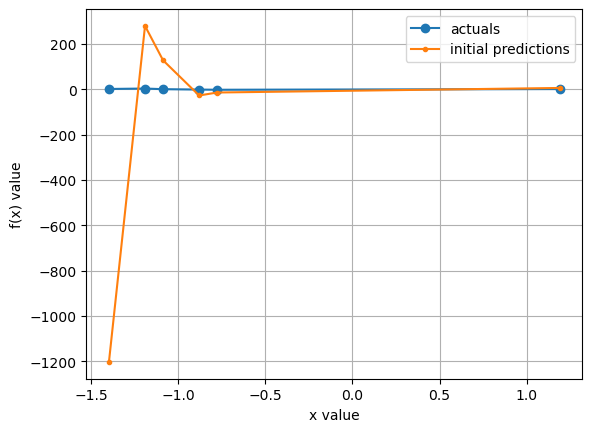

In [124]:
fig, ax = plt.subplots()

p1 = ax.plot(x_test, y_test, "-o", label="actuals")
p2 = ax.plot(x_test, test_predictions, ".-", label="initial predictions")

ax.legend()
ax.set_xlabel("x value")
ax.set_ylabel("f(x) value")
plt.grid()
plt.show()

## Closed form solution with regularization

Let's assume we have a dataset with `n` observations and `m` features. The features are represented by the vector `θ`.

The cost function for linear regression with regularization is given by:

$$J(θ) = \frac{1}{2n} \sum_{i=1}^{n} (h_θ(x^{(i)}) - y^{(i)})^2 + \frac{λ}{2n} \sum_{j=1}^{m} θ_j^2$$

where `λ` is the regularization parameter and `h_θ(x)` is the hypothesis function given by:

$$h_θ(x) = θ^Tx$$

To find the closed form solution, we need to find the value of `θ` that minimizes the cost function `J(θ)`.

Taking the partial derivative of `J(θ)` with respect to `θ_j`, we get:

$$\frac{∂J(θ)}{∂θ_j} = \frac{1}{n} \sum_{i=1}^{n} (h_θ(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{λ}{n} θ_j$$

Setting this derivative to 0 and solving for `θ`, we get:

$$\theta = (X^TX + λI)^{-1}X^Ty$$

where `X` is the design matrix of shape `(n, m+1)` and `y` is the vector of target values of shape `(n,)`.

Let's derive this solution step by step.

First, let's expand the cost function:

$$J(θ) = \frac{1}{2n} \sum_{i=1}^{n} (h_θ(x^{(i)}) - y^{(i)})^2 + \frac{λ}{2n} \sum_{j=1}^{m} θ_j^2$$
$$= \frac{1}{2n} \sum_{i=1}^{n} (θ^Tx^{(i)} - y^{(i)})^2 + \frac{λ}{2n} \sum_{j=1}^{m} θ_j^2$$
$$= \frac{1}{2n} (Xθ - y)^T(Xθ - y) + \frac{λ}{2n} θ^Tθ$$

where `X` is the design matrix of shape `(n, m+1)` and `y` is the vector of target values of shape `(n,)`.

Taking the derivative with respect to `θ`, we get:

$$\frac{∂J(θ)}{∂θ} = \frac{1}{n}(X^TX + λI)θ - X^Ty$$

Setting this derivative to 0 and solving for `θ`, we get:

$$(X^TX + λI)θ = X^Ty$$
$$(X^TX + λI)^{-1}(X^TX + λI)θ = (X^TX + λI)^{-1}X^Ty$$
$$\theta = (X^TX + λI)^{-1}X^Ty$$

In [125]:
def linear_regression_closed_form_regularized(X, y, lmbda=0):
    a = np.linalg.inv(X.T @ X + lmbda * np.eye(X.shape[1])) @ X.T @ y
    return a

# create the training matrix
order_of_polynomial = 18
X_train_matrix = np.array([np.power(x_train, ix) for ix in range(order_of_polynomial)]).T

# train the model
lmda = 10
a = linear_regression_closed_form_regularized(X_train_matrix, y_train, lmda)

# make predictions on new data
predictions = np.dot(X_train_matrix, a)

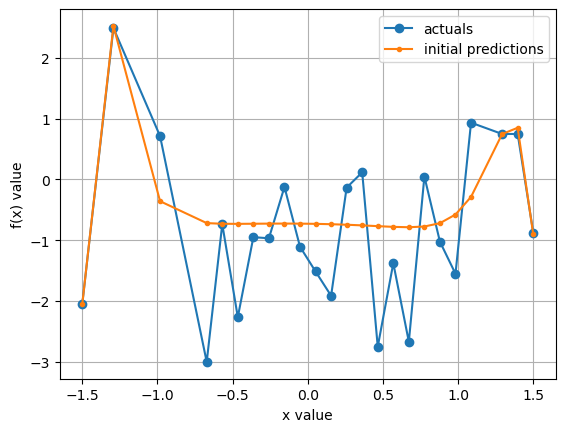

In [126]:
fig, ax = plt.subplots()
p1 = ax.plot(x_train, y_train, "-o", label="actuals")
p2 = ax.plot(x_train, predictions, ".-", label="initial predictions")
ax.legend()
ax.set_xlabel("x value")
ax.set_ylabel("f(x) value")
plt.grid()
plt.show()

In [127]:
print(f"The Mean squared error of closed form solution for train set is: {get_loss_vectorised(predictions, y_train)}")

The Mean squared error of closed form solution for train set is: 0.979677473731082


In [128]:
X_test_matrix = np.array([np.power(x_test, ix) for ix in range(order_of_polynomial)])
test_predictions = a @ X_test_matrix
print(f"The Mean squared error of closed form solution is: {get_loss_vectorised(test_predictions, y_test)}")

The Mean squared error of closed form solution is: 2.1177163044838525


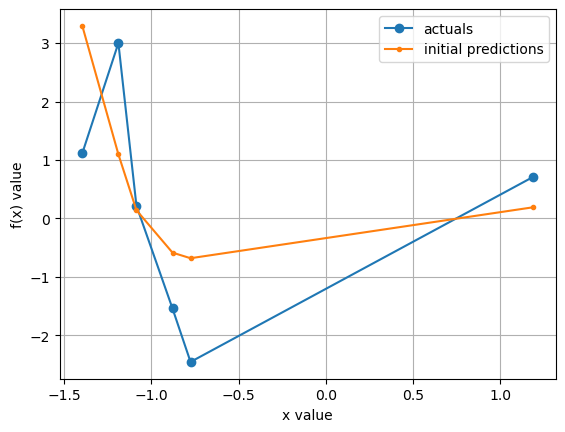

In [129]:
fig, ax = plt.subplots()

p1 = ax.plot(x_test, y_test, "-o", label="actuals")
p2 = ax.plot(x_test, test_predictions, ".-", label="initial predictions")

ax.legend()
ax.set_xlabel("x value")
ax.set_ylabel("f(x) value")
plt.grid()
plt.show()

## Understanding the effect regularization and model complexity

To better understand the effect of the order of the polynomial function and value of the regularization term on the final model can be seen below. Use the sliders to see how the model shape changes.

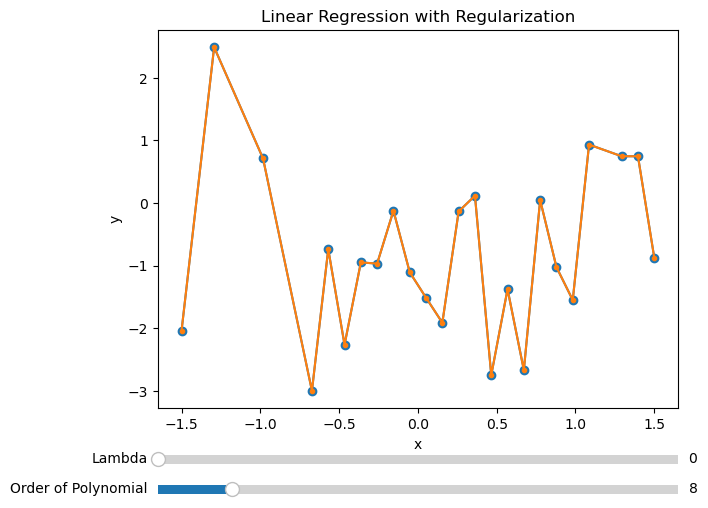

In [130]:
fig, ax = plt.subplots(figsize=(8,6))
plt.subplots_adjust(left=0.25, bottom=0.25)
line1, = ax.plot(x_train, y_train, '-o')
line2, = ax.plot(x_train, y_train, '.-')

ax.set_title('Linear Regression with Regularization')
ax.set_xlabel('x')
ax.set_ylabel('y')

axcolor = 'lightgoldenrodyellow'
ax_order_of_polynomial = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
ax_lmda = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

s_order_of_polynomial = Slider(ax_order_of_polynomial, 'Order of Polynomial', 1, 50, valinit=8, valstep=1)
s_lmda = Slider(ax_lmda, 'Lambda', 0, 500, valinit=0)

def update(val):
    order_of_polynomial = int(s_order_of_polynomial.val)+1
    lmda = s_lmda.val
    X_train_matrix = np.array([np.power(x_train, ix) for ix in range(order_of_polynomial)]).T
    a = linear_regression_closed_form_regularized(X_train_matrix, y_train, lmda)
    predictions = np.dot(X_train_matrix, a)
    line2.set_ydata(predictions)
    fig.canvas.draw_idle()

s_order_of_polynomial.on_changed(update)
s_lmda.on_changed(update)

plt.show()

## Issues with closed form solution

While we are able fit a n-th order polynomial curve to the given data quite well using the closed form solution. The problem is that it involves a matrix inversion operation which is computationally very expensive(complexity of $O(m^3)$). As the dataset size increases it becomes more and more difficult to calculate the inverse.

It is also possible that the given **X** matrix has no inverse. And since the entire **X** matrix needs to be stored in the memory for inversion, we have additional memory constraints as well.

In the below 2 cells you can see the increase in time taken to compute the inverse with respect to the increase in matrix size. And you can see there is approximately a 10x increase in time for 2x increase in matrix size.

In [131]:
sizes = [100, 200, 1000, 2000, 3000] #, 2000, 3000, 4000, 6000, 8000, 12000]
times = []
for size in sizes:
    A = np.random.rand(size, size)
    start = time()
    np.linalg.inv(A)
    end = time()
    t = end - start
    times.append(t)

In [132]:
len(sizes)

5

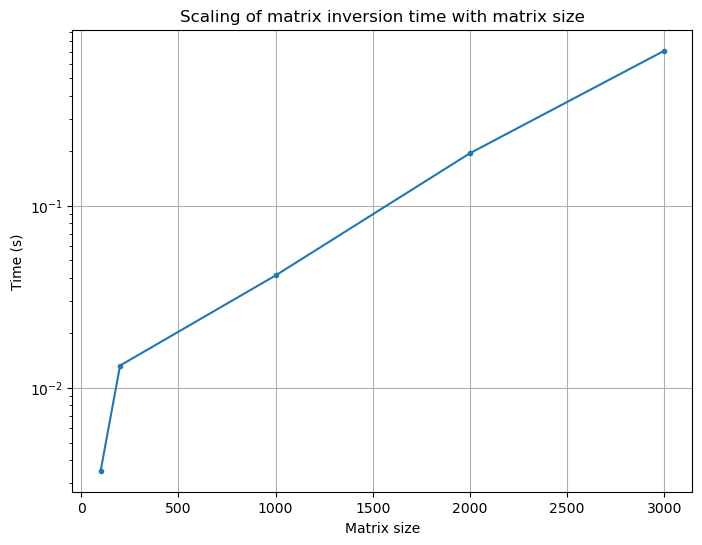

In [133]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(sizes, times, ".-")
ax.set_yscale("log")
ax.set_xlabel("Matrix size")
ax.set_ylabel("Time (s)")
ax.set_title('Scaling of matrix inversion time with matrix size')
plt.grid()
plt.show()

# Gradient descent

Gradient descent is an iterative way to calculate the minima of a given function.
We will treat the problem of finding the right model parameters to the model as a minimization problem. That is, we will arrive at the minimum value of the loss function iteratively by updating the model parameters in the direction of the minima.

At each step we will calculate the direction of steepest descent for each of the model parameters and take a step in that direction.

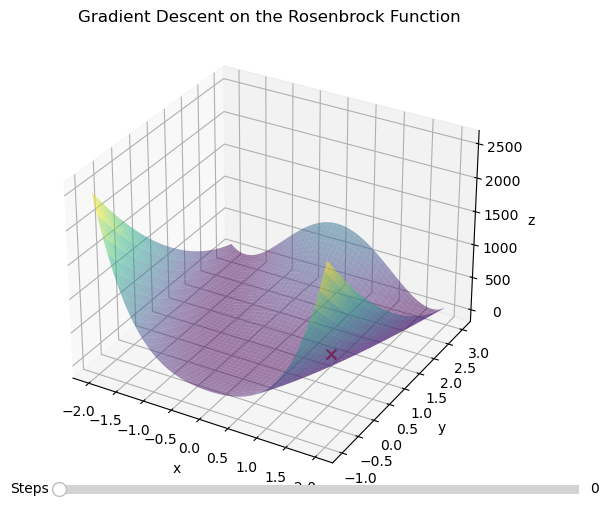

In [88]:
# Define the Rosenbrock function
def rosenbrock(x, y):
    return (1 - x)**2 + 100*(y - x**2)**2

# Define the gradient of the Rosenbrock function
def gradient(x, y):
    dx = -2*(1 - x) - 400*x*(y - x**2)
    dy = 200*(y - x**2)
    return dx, dy

# Set the initial values of x and y
x = 0
y = 2.7

# Set the learning rate
learning_rate = 0.001

# Create the figure and axes objects
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface of the Rosenbrock function
X, Y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-1, 3, 100))
Z = rosenbrock(X, Y)
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)

# Add a marker at the minimum point
ax.scatter(1, 1, 0, s=50, c='r', marker='x')

# Set the axis titles and plot title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Gradient Descent on the Rosenbrock Function')

# Create the line object for the trajectory of gradient descent
line, = ax.plot([], [], [], 'r', lw=2)

# Create a list to store the trajectory of gradient descent
trajectory = [(x, y)]

# Create the slider for the number of steps
ax_steps = plt.axes([0.25, 0.1, 0.65, 0.03])
s_steps = Slider(ax_steps, 'Steps', 0, 1000, valinit=0)

# Define the update function for the slider
def update(val):
    global x, y
    steps = int(s_steps.val)
    if steps < len(trajectory):
        trajectory[:] = trajectory[:steps]
        x, y = trajectory[-1]
    else:
        for i in range(steps - len(trajectory) + 1):
            dx, dy = gradient(x, y)
            x -= learning_rate * dx
            y -= learning_rate * dy
            trajectory.append((x, y))
    line.set_data([p[0] for p in trajectory], [p[1] for p in trajectory])
    line.set_3d_properties([rosenbrock(p[0], p[1]) for p in trajectory])
    fig.canvas.draw_idle()

s_steps.on_changed(update)

plt.show()

![SegmentLocal](grad_descent.gif "segment")

***source: https://towardsdatascience.com/gradient-descent-animation-1-simple-linear-regression-e49315b24672***

## Making an initial guess

Since we have no idea what the coefficients **a** are, let us start with a random initial guess. We will come up with rules to update these values or **"weights"** so that our model gives the correct $y$ values for the given $x$ values. 

We will use an array **a** to store the values of the constants where **a[i]** corresponds to $a_i$

In [134]:
def get_random_intialization(size=11):
    np.random.seed(42)
    a = np.random.rand(size)
    return a

a = get_random_intialization(17)
a

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258,
       0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497,
       0.18340451, 0.30424224])

Let us see how the function looks when we set **a** to random values

we will make use of a small python function get_prediction_vector(), which takes the coefficient vector **a** as input along with the value for $x$ and returns $f(x)$ using our guess function.

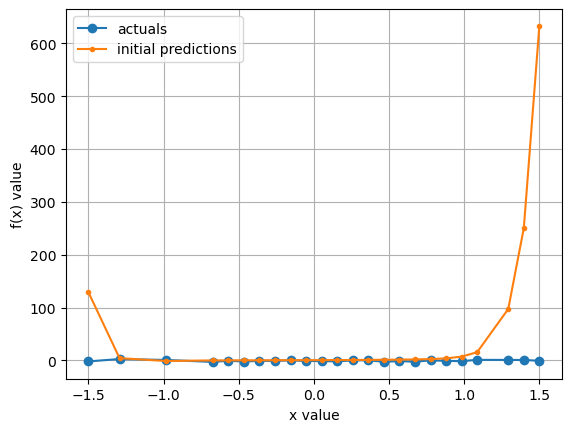

In [135]:
def get_prediction_vector(coef_vector, x):
    X_matrix = np.array([np.power(x, i).T for i in range(len(coef_vector))]).T
    y = X_matrix@coef_vector
    return y

initial_predictions = get_prediction_vector(a, x_train)

fig, ax = plt.subplots()
p1 = ax.plot(x_train, y_train, "o-", label="actuals")
p2 = ax.plot(x_train, initial_predictions, ".-", label="initial predictions")
ax.legend()
ax.set_xlabel("x value")
ax.set_ylabel("f(x) value")
plt.grid()
plt.show()

## Updating our model parameters

As we can see above, our initial guess is very poor. The blue dots which represent the actual $f(x)_{actual}$ are in no way close to the orange dots which represent $f(x)_{prediction}$ from our initial guess function.

It is worth remembering again that $f(x)_{actual}$ is given to us along with the $x$ values.

Now we need to decide how to update our initial guess. For each of our weights in a we have some very
simple options: either increase the value or reduce the value by a certain amount.

We should choose the correct option, that is increase or decrease each feature in **a** so that ultimately our loss(**MSE**) is as close to 0 as possible.

The equation for gradient descent update is:

$$\theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$$

where:
- $\theta_j$ is the j-th parameter (weight) of the model
- $\alpha$ is the learning rate
- $m$ is the number of training examples
- $h_\theta(x^{(i)})$ is the hypothesis function for linear regression
- $x_j^{(i)}$ is the j-th feature of the i-th training example
- $y^{(i)}$ is the target value for the i-th training example

### Stochastic vs Batch Gradient Descent

As you can see above 2 variants of Gradient descent have been implemented. 

Batch gradient descent computes the gradient of the cost function with respect to the model parameters using the **entire training dataset** in each iteration. 

Stochastic gradient descent, on the other hand, computes the gradient using only a **single training example** in each iteration.

Batch gradient descent is more accurate since the gradient is computed using the entire training dataset, but it requires higher computational and memory resources.

A compromise between the 2 is generally used, which is called **Mini-Batch gradient descent**. Here, chunks of the input dataset are used to calculate the gradient.

#### Task:
Try to implement minibatch gradient descent where the gradient is calculated using a batch size of 8. At each step, the gradient is calculated using 8 training samples at a time. Note that it is not imperative the given dataset be a multiple of 8. In these cases the final batch will simply be smaller.

### Pseudocodes (for understanding)

**Batch Gradient Descent**
```
for epoch in number of epochs:
    - for all the training instances in the dataset compute the derivative of the cost function
    - update the weights
```
**Stochastic Gradient Descent**
```
for epoch in number of epochs:
    for instance in total dataset:
        - for the current instance compute the derivative of the cost function 
        - update the weights
```

**Mini Batch Gradient Descent**
```
for epoch in number of epochs:
    for batch in num of batches:
        - for all the training instances in the batch sample compute the derivative of the cost function
        - update the weights
```

#### Example: 

- dataset with 1000 samples : **m** = 1000
- for each variant of gradient descent, we have 100 number of epochs (updates): **n_epochs** = 100
- for mini-batch descent, we choose a batch size of 100: **batch_size** = 100
    - the number of iterations (**n_iterations**) for mini-batch descent to cover all samples are 10: (**m** / **batch_size** = 1000 / 100) = 10
    
Number of weight updates: 
- for batch gradient descent: **n_epochs** = 100
- for stochastic gradient descent: **n_epochs** * **m** = 100 * 1000 = 100,000
- for mini-batch gradient descent: **n_iterations** * **n_epochs** = 10 * 100 = 1000




In [91]:
def update_weights_sgd_regularized(a, prediction, y_train, x_train, lr=0.00000001, reg_lambda=0.01):
    for i in range(len(y_train)):
        error = prediction[i] - y_train[i]
        a[0] = a[0] - lr * (error + reg_lambda * a[0])
        for j in range(1, len(a)): #for the polynomial terms with order greater than 1  
            a[j] = a[j] - lr * (error * np.power(x_train[i],j) + reg_lambda * a[j])
    return a

def update_weights_batch(a , predictions, actuals, x_train, lr=0.00000001):
    a[0] = a[0] - lr * np.sum((predictions-actuals)) / len(predictions)
    for ix in range(1, len(a)):
        a[ix] = a[ix] - lr * ((predictions-actuals))@(np.power(x_train, ix)).T  / len(predictions)
    return a

def update_weights_batch_regularized(a , predictions, actuals, x_train, lr=0.00000001, reg_lambda=0.01):
    a[0] = a[0] - lr * (np.sum((predictions-actuals)) / len(predictions) + reg_lambda * a[0])
    for ix in range(1, len(a)):
        a[ix] = a[ix] - lr * (((predictions-actuals))@(np.power(x_train, ix)).T  / len(predictions) + reg_lambda * a[ix])
    return a

#Try to write a non regularized function for stochastic gradient descent
def update_weights_sgd(a, prediction, y_train, x_train, lr=0.00000001):
    #code here
    return a

#Functions for regularized and non-regularized Mini batch gradient descent
def update_weights_mbgd(a , predictions, actuals, x_train, lr=0.00000001, batch_size=8):
    #code here
    return a
def update_weights_mbgd_regularized(a , predictions, actuals, x_train, lr=0.00000001, batch_size=8, reg_lambda=0.01):
    #code here
    return a

In [137]:
#we will initialize random weights for polynomial of order 17
a = get_random_intialization(17)
predictions = get_prediction_vector(a, x_train)

#lists loss_history and weights_history will be used to store the all the losses and 
#weights in all the epochs to visualize the optimization process later
loss_history = [get_loss_vectorised(predictions, y_train)]
weights_history = [list(a)]

In [138]:
iters = 1000 #or number of epochs

pbar = tqdm.tqdm(range(iters))
# for epoch in number of epochs:
for itex in pbar: 
    # use initialized values with gradient descent function
    #a_next = update_weights_sgd_regularized(a, predictions, y_train, x_train, lr=0.000001)
    a_next = update_weights_batch_regularized(a, predictions, y_train, x_train, lr = 0.000001, reg_lambda = 0.01)
    
    # use updated weights for making predictions
    predictions = get_prediction_vector(a_next, x_train)
    weights_history.append(list(a_next)) #store weights history
    a = a_next #assign weights for next interation with the updated weights
    
    loss_history.append(get_loss_vectorised(predictions, y_train)) #compute and store loss
    pbar.set_description(f'Current loss: {np.round(loss_history[-1],2)}') 

Current loss: 76.02: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.14it/s]


In [94]:
x_train.shape

(24,)

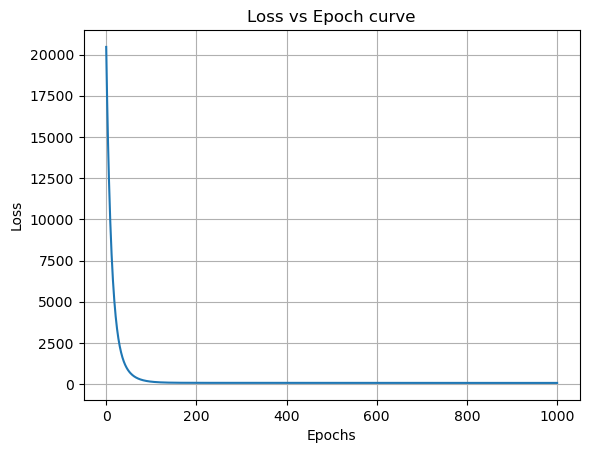

In [139]:
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epoch curve")
plt.grid()
plt.show()

In [140]:
plt.clf()
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100  
plt.ioff()
#fig, ax = plt.subplots()
fig, ax = plt.subplots(1,3,figsize=(18,6))

weights_history = np.array(weights_history)

def animate(ix):
    ax[0].clear()
    
    p1 = ax[0].plot(x_train, y_train, "o-", label="actuals")
    
    #a, b = weights_history[ix]
    
    predictions = get_prediction_vector(weights_history[ix], x_train)

    p2 = ax[0].plot(x_train, predictions, ".-", label="predictions")

    p3 = ax[1].plot( weights_history[:ix, 0], loss_history[:ix], ".-")
    p4 = ax[2].plot( weights_history[:ix, 1], loss_history[:ix], ".-")
    ax[0].set_xlabel("x_train value")
    ax[0].set_ylabel("function output value")
    
    ax[1].set_xlabel("Weight a")
    ax[1].set_ylabel("Loss value")
    ax[2].set_xlabel("Weight b")
    ax[2].set_ylabel("Loss value")
    
    ax[0].legend()
    plt.draw()
        
matplotlib.animation.FuncAnimation(fig, animate, frames=range(0,iters,20))

## Real life example

### Boston Housing dataset

The Boston Housing Dataset is a derived from information collected by the U.S. Census Service concerning housing in the area of Boston MA. The following describes the dataset columns:

    CRIM - per capita crime rate by town
    ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
    INDUS - proportion of non-retail business acres per town.
    CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    NOX - nitric oxides concentration (parts per 10 million)
    RM - average number of rooms per dwelling
    AGE - proportion of owner-occupied units built prior to 1940
    DIS - weighted distances to five Boston employment centres
    RAD - index of accessibility to radial highways
    TAX - full-value property-tax rate per \$10,000
    PTRATIO - pupil-teacher ratio by town
    B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    LSTAT - % lower status of the population
    MEDV - Median value of owner-occupied homes in $1000's

The dataset can be also downloaded from Kaggle. 
**https://www.kaggle.com/datasets/schirmerchad/bostonhoustingmlnd/data**


In [141]:
df_housing = pd.read_csv("bostonHousing.csv")
df_housing

crim    zn  indus  chas    nox       rm   age        dis  rad  tax  \
0    0.00632  18.0   2.31     0  538.0  6575.00  65.2     4.0900    1  296   
1    0.02731   0.0   7.07     0  469.0  6421.00  78.9     4.9671    2  242   
2    0.02729   0.0   7.07     0  469.0  7185.00  61.1     4.9671    2  242   
3    0.03237   0.0   2.18     0  458.0  6998.00  45.8     6.0622    3  222   
4    0.06905   0.0   2.18     0  458.0  7147.00  54.2     6.0622    3  222   
..       ...   ...    ...   ...    ...      ...   ...        ...  ...  ...   
501  0.06263   0.0  11.93     0  573.0  6593.00  69.1     2.4786    1  273   
502  0.04527   0.0  11.93     0  573.0     6.12  76.7     2.2875    1  273   
503  0.06076   0.0  11.93     0  573.0  6976.00  91.0     2.1675    1  273   
504  0.10959   0.0  11.93     0  573.0  6794.00  89.3     2.3889    1  273   
505  0.04741   0.0  11.93     0  573.0     6.03  80.8  2505.0000    1  273   

     ptratio       b  lstat  medv  
0       15.3  396.90   4.98  24.0  
1       17.8  396.90   9.14  21.6  
2       17.8  392.83   4.03  34.7  
3       18.7  394.63   2.94  33.4  
4       18.7  396.90   5.33  36.2  
..       ...     ...    ...   ...  
501     21.0  391.99   9.67  22.4  
502     21.0  396.90   9.08  20.6  
503     21.0  396.90   5.64  23.9  
504     21.0  393.45   6.48  22.0  
505     21.0  396.90   7.88  11.9  

[506 rows x 14 columns]

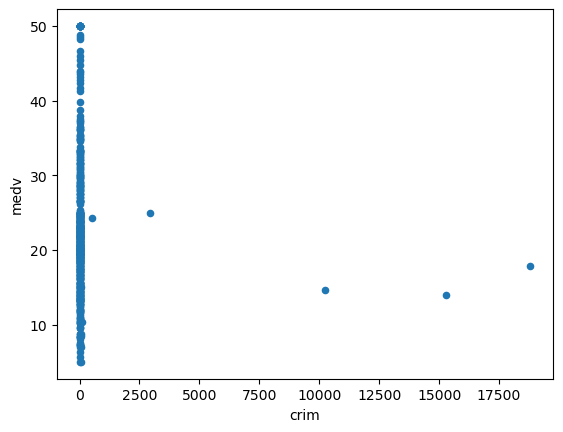

In [143]:
df_housing.plot("crim", "medv", kind="scatter")
plt.show()

In [99]:
np.max(df_housing["indus"])

27.74

In [100]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df_housing["indus"], df_housing["medv"],  ".")
ax.set_ylabel("Median value of owner-occupied homes in $1000's")
ax.set_xlabel("Proportion of non-retail business acres per town")
ax.set_title("Sample scatter plot for visualizing effect of feature 'indus' on output 'medv' ")
plt.grid("on")
plt.savefig("sample_scatter.png", bbox_inches="tight", dpi=300)

### Tasks

1. Let **medv** be the value to be predicted, and the other columns be the input features. See if you are able to develop a linear regression model to predict the Median housing value.

2. Split the dataset into test and train sets. Pick a reasonable ratio, 80% train and 20% test.

3. Go through the steps we went with above and look at the effects of regularization.

4. Before training the model, plot scatter plots to see how each of the input features correlate to the **medv**